## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

pd.options.display.max_columns = 25
sns.set_style('darkgrid')

In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

In [3]:
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import callbacks
from tensorflow.keras import utils

# Dataset

In [4]:
train = pd.read_csv("../input/cat-in-the-dat/train.csv")
print(train.shape)
train.head()

(300000, 25)


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [5]:
test = pd.read_csv("../input/cat-in-the-dat/test.csv")
sample = pd.read_csv("../input/cat-in-the-dat/sample_submission.csv")

In [6]:
test["target"] = -1
data = pd.concat([train, test]).reset_index(drop=True)
features = [x for x in train.columns if x not in ["id", "target"]]

for feat in features:
    lbl_enc = LabelEncoder()
    data[feat] = lbl_enc.fit_transform(data[feat].values)

In [7]:
data.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,1,1,1,5,5,3,0,78,120,491,1689,2192,1,2,1,7,3,136,1,1,0
1,1,0,1,0,1,1,1,4,3,5,2,159,510,260,652,11719,0,2,3,0,0,93,6,7,0
2,2,0,0,0,0,1,0,4,4,5,3,44,14,766,1935,8140,0,1,4,7,17,31,6,1,0
3,3,0,1,0,0,1,2,4,5,0,1,209,165,1121,631,6098,0,2,0,8,3,134,1,0,1
4,4,0,0,0,0,0,2,4,4,0,1,90,61,34,1763,8293,0,2,2,0,17,158,6,7,0


# Modelling

In [8]:
train = data[data.target != -1].reset_index(drop=True)
test = data[data.target == -1].reset_index(drop=True)
test_data = [test.iloc[:, k+1].values for k in range(len(features))]

X = [train.iloc[:, k+1] for k in range(len(features))]
y = utils.to_categorical(train.target.values)

In [9]:
def auroc(y_true, y_pred):
    def fallback_auc(y_true, y_pred):
        try:
            return roc_auc_score(y_true, y_pred)
        except:
            return 0.5
    return tf.py_function(fallback_auc, (y_true, y_pred), tf.double)

## Baseline Model
One Hot Encoding -> LogisticRegression

In [10]:
%%time

X_ = OneHotEncoder().fit_transform(train[features])
y_ = train.target

print('Baseline Score:', np.mean(cross_val_score(LogisticRegression(max_iter=100_000), X_, y_, scoring='roc_auc')))

Baseline Score: 0.796822621508035
CPU times: user 2min 44s, sys: 261 ms, total: 2min 44s
Wall time: 2min 45s


## Entity Embeddings

In [11]:
es = callbacks.EarlyStopping(
    monitor='val_auroc', min_delta=0.001, patience=7, verbose=1, mode='max', baseline=None,
    restore_best_weights=True
)

rlp = callbacks.ReduceLROnPlateau(
    monitor='val_auroc', factor=0.5, patience=3, min_lr=1e-6, mode='max', verbose=1
)

class config():
    EMBEDDING_DIM = 64
    SPATIAL_DROPOUT = 0.3
    HIDDEN_LAYERS = [(300, 'relu', 0.3), (300, 'relu', 0.3)]
    OUTPUT_CELLS = 2
    OUTPUT_ACTIVATION = 'softmax'
    LOSS = 'binary_crossentropy'
    OPT = 'adam'
    METRICS = [auroc]
    BATCH_SIZE = 1024
    MAX_EPOCHS = 100
    CALL_BACKS = [es, rlp]

In [12]:
def create_model(data, catcols):    
    inputs = []
    outputs = []
    for c in catcols:
        num_unique_values = int(data[c].nunique())
        inp = layers.Input(shape=(1,))
        out = layers.Embedding(num_unique_values + 1, config.EMBEDDING_DIM, name=c)(inp)
        out = layers.SpatialDropout1D(config.SPATIAL_DROPOUT)(out)
        out = layers.Reshape(target_shape=(config.EMBEDDING_DIM, ))(out)
        inputs.append(inp)
        outputs.append(out)
    
    x = layers.Concatenate()(outputs)
    x = layers.BatchNormalization()(x)
    
    for n_cells, act_fn, dropout in config.HIDDEN_LAYERS:
        x = layers.Dense(n_cells, activation=act_fn)(x)
        x = layers.Dropout(dropout)(x)
        x = layers.BatchNormalization()(x)
    
    y = layers.Dense(config.OUTPUT_CELLS, activation=config.OUTPUT_ACTIVATION)(x)

    model = Model(inputs=inputs, outputs=y)
    return model

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
_______________________________________________________________________________________

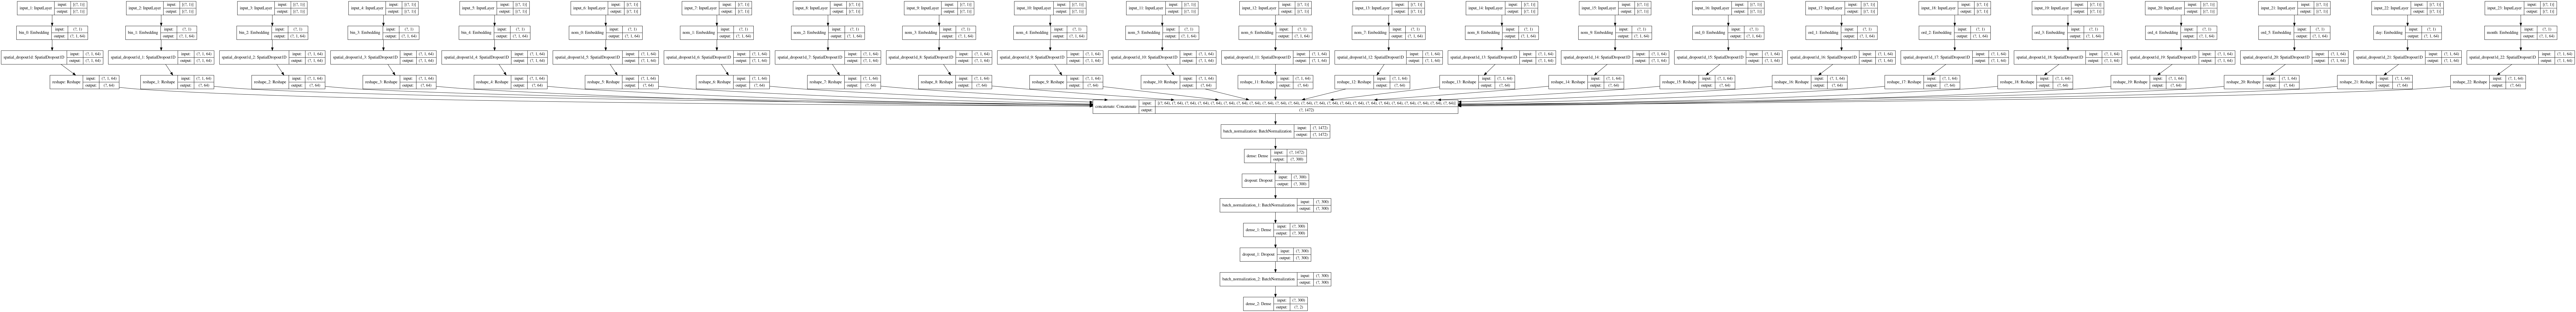

In [13]:
model = create_model(data, features)
model.compile(loss=config.LOSS, optimizer=config.OPT, metrics=config.METRICS)
model.summary()
utils.plot_model(model, show_shapes=True)

In [14]:
history =  model.fit(
    X, y, validation_split=0.1, 
    batch_size=config.BATCH_SIZE, callbacks=config.CALL_BACKS, epochs=config.MAX_EPOCHS
)

Epoch 1/100
264/264 [==============================] - 8s 29ms/step - loss: 0.5873 - auroc: 0.7167 - val_loss: 0.5745 - val_auroc: 0.7864
Epoch 2/100
264/264 [==============================] - 7s 28ms/step - loss: 0.4936 - auroc: 0.7926 - val_loss: 0.5041 - val_auroc: 0.7988
Epoch 3/100
264/264 [==============================] - 7s 27ms/step - loss: 0.4744 - auroc: 0.8122 - val_loss: 0.4885 - val_auroc: 0.7983
Epoch 4/100
264/264 [==============================] - 7s 27ms/step - loss: 0.4631 - auroc: 0.8228 - val_loss: 0.4939 - val_auroc: 0.7951
Epoch 5/100
264/264 [==============================] - ETA: 0s - loss: 0.4514 - auroc: 0.8324
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
264/264 [==============================] - 7s 26ms/step - loss: 0.4514 - auroc: 0.8324 - val_loss: 0.5015 - val_auroc: 0.7904
Epoch 6/100
264/264 [==============================] - 8s 29ms/step - loss: 0.4304 - auroc: 0.8494 - val_loss: 0.5174 - val_auroc: 0.7826
Epoch 7/10

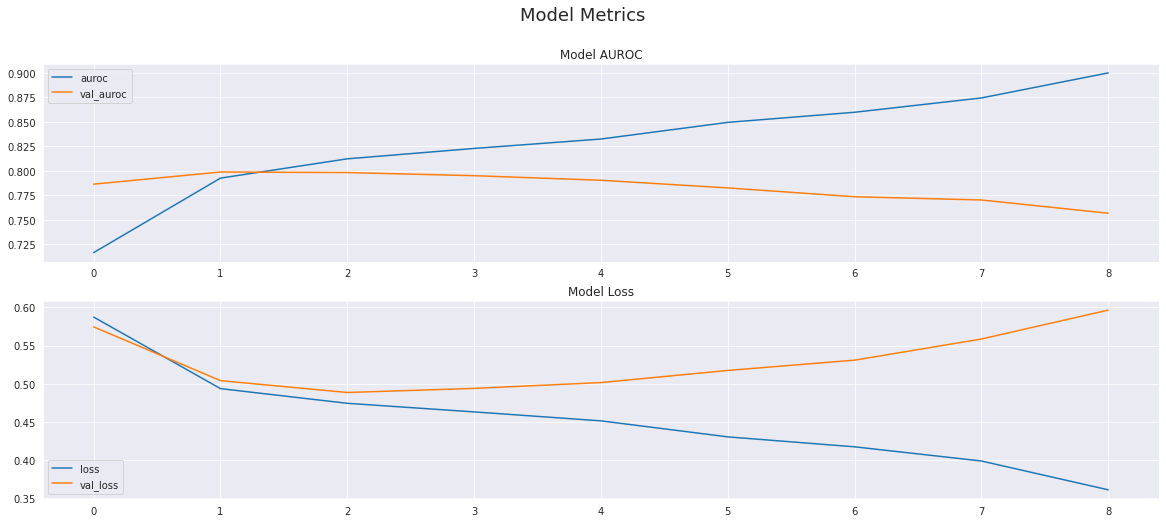

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
df = pd.DataFrame(history.history)
df[['auroc', 'val_auroc']].plot(ax=ax[0])
df[['loss', 'val_loss']].plot(ax=ax[1])
ax[0].set_title('Model AUROC', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18);

In [16]:
pd.DataFrame({
    'id': test.id.values,
    'target': model.predict(test_data)[:, 1]
}).to_csv("submission.csv", index=False)

**Score:** 0.80221

## Hybrid Model

Entity Embeddings -> Catboost

In [17]:
encoder = Model(inputs=model.input, outputs=model.layers[-8].output)
embeddings_train = encoder.predict(X)
embeddings_test = encoder.predict(test_data)

In [18]:
%%time

estimator = CatBoostClassifier(task_type="GPU", silent=True).fit(embeddings_train, y[:, 1])

pd.DataFrame({
    'id': test.id.values,
    'target': estimator.predict_proba(embeddings_test)[:, 1]
}).to_csv(f"submission_hybrid.csv", index=False)

CPU times: user 2min 27s, sys: 13.7 s, total: 2min 40s
Wall time: 2min 12s


**Score:** 0.79553

# References
[Entity Embeddings of Categorical Variables](https://arxiv.org/pdf/1604.06737v1.pdf)